In [1]:
import os 
import sys

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

import toast

import scipy.signal as si

import pysm3
import pysm3.units as usm

import skytools

import astropy.units as u 
import astropy as astro

from scipy.optimize import curve_fit
from scipy.linalg import sqrtm

In [2]:
env = toast.utils.Environment.get()
comm, procs, rank = toast.get_world()
nthread = os.environ["OMP_NUM_THREADS"]

In [3]:
mem = toast.utils.memreport(msg="(whole node)", comm=comm, silent=False)

Memory usage (whole node)
       total :  503.138 GB
   available :  250.988 GB
     percent :   50.100 % 
        used :  218.071 GB
        free :  219.891 GB
      active :   13.858 GB
    inactive :  183.388 GB
     buffers :   54.910 MB
      cached :   65.123 GB
      shared :    3.050 GB
        slab :   41.663 GB



0. Read Planck map

In [4]:
NSIDE = 512
lmax = 2*NSIDE

In [5]:
resol = hp.nside2resol(nside=NSIDE)
amin2rad = np.pi/(60*180)

resol_amin = resol*amin2rad

print(resol)

0.0019986849764579854


In [6]:
rGC = hp.rotator.Rotator(coord=['G','C'])  # Transforms galactic to equatorial coordinates


In [100]:
truesky_GC512 = hp.read_map(filename='cmb_030_GC_nside_I.FITS',field=None)

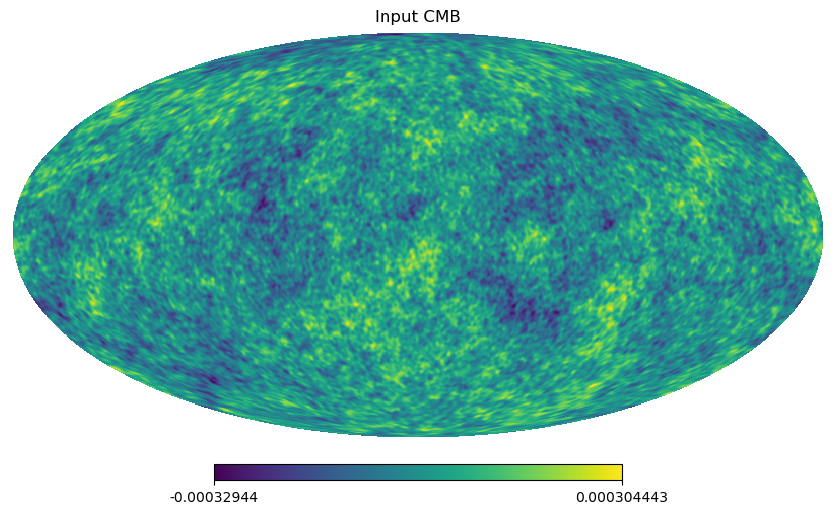

In [8]:
hp.mollview(truesky_GC512[0],title = 'Input CMB')

Scale-invariant power spectrum

In [9]:
def D_ell(maps, lmax, use_pixel_weights=False):
    l_arr = np.arange(0,lmax+1)
    cl_s = hp.anafast(maps, lmax=lmax,use_pixel_weights=use_pixel_weights)
    return (cl_s[:]*l_arr*(l_arr+1)/(2*np.pi))

In [10]:
l_arr = np.arange(0,lmax+1)

Create a telescope and corresponding pointing

1. Start by creating a focalplane with a sample rate and number of detectors

In [11]:
from toast.qarray import to_iso_angles, rotation, mult, to_lonlat_angles
#xrot = rotation([1,0,0], np.pi/2)
xrot = rotation([0,1,0], np.pi/2)
#xrot = rotation([0,0,1], np.pi/2)


In [12]:
from toast.instrument_sim import fake_hexagon_focalplane, plot_focalplane

In [13]:
focalplane = toast.instrument.Focalplane(sample_rate=10*u.Hz#,thinfp=256
                                        )
##One fourth of total detectors in the focalplane
## For S4, sample rate ~10-100

with toast.io.H5File("focalplane_SAT3_SAT_f030.h5", "r", comm=comm, force_serial=True) as f:
            focalplane.load_hdf5(f.handle, comm=comm)

Print focalplane information

In [14]:
iso_angles = np.array([np.degrees(to_iso_angles(mult(xrot,focalplane[detec]["quat"]))) for detec in focalplane.detectors])


Define the schedule, site and telescope

In [15]:
focalplane._det_to_row = {'029_000_SAT_f030_A': 0,
  '029_003_SAT_f030_A': 6}

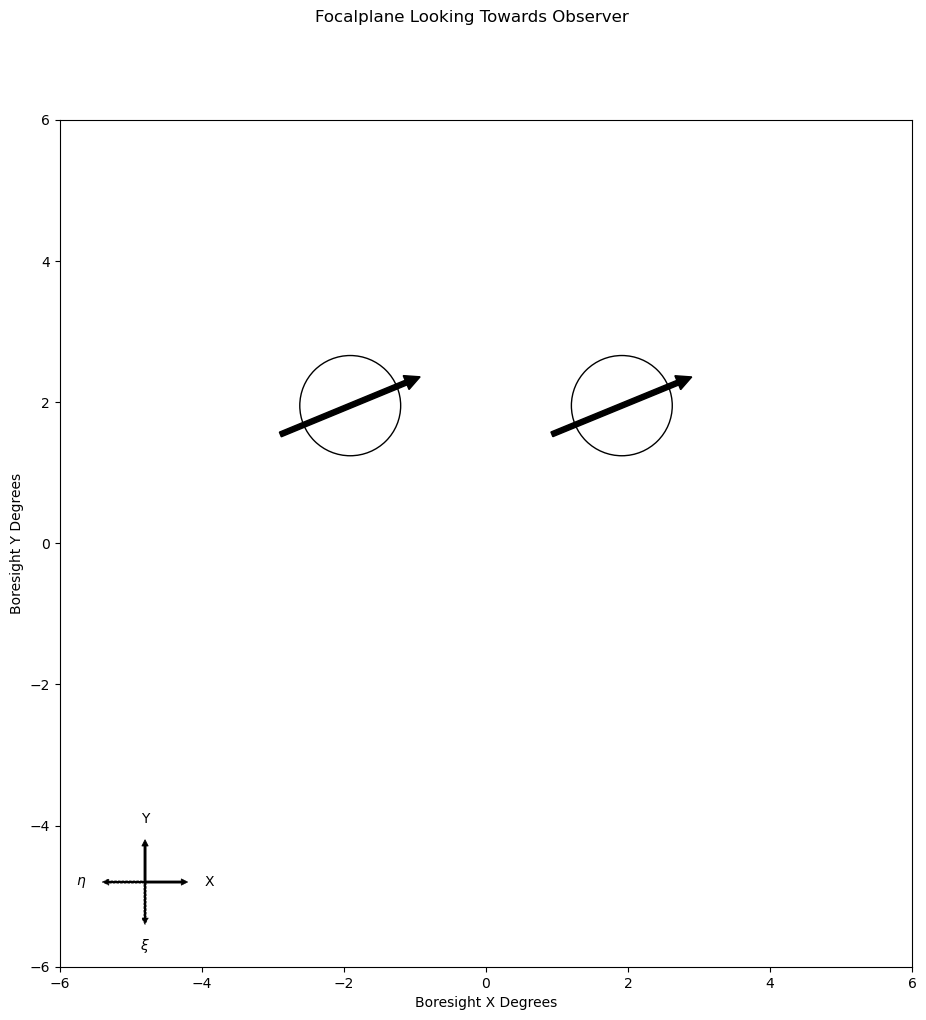

<Figure size 640x480 with 0 Axes>

In [16]:
plot_focalplane(focalplane, width=10*u.degree, height = 10*u.degree)
plt.savefig('two_detectors.png')

Print schedule information

In [17]:
schedule = toast.schedule.GroundSchedule()
schedule.read("POLE_DEEP_169-DEC0.txt", comm=comm)

TOAST INFO: Loading schedule from POLE_DEEP_169-DEC0.txt
TOAST INFO: Loaded 1 scans from POLE_DEEP_169-DEC0.txt totaling 84.0 minutes.


In [18]:
schedule

<GroundSchedule site=SOUTH_POLE at -90.0 deg, -44.65 deg, 2843.0 m telescope SAT with 1 scans
  <GroundScan 'POLE_DEEP' at 2027-05-28T06:00:00+00:00 with El = 52.6 deg, Az 63.59 deg -- 134.26 deg>
>

Print telescope information

In [19]:
site = toast.instrument.GroundSite(
        schedule.site_name,
        schedule.site_lat,
        schedule.site_lon,
        schedule.site_alt,
        weather=None,
    )
telescope = toast.instrument.Telescope(
        "My_telescope", focalplane=focalplane, site=site
    )

telescope

<Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -90.0 deg, alt = 2843.0 m, weather = None>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 029_003_SAT_f030_A]>>

We can have multiple groups for parallel computing (start with one). Create a Data Instance and simulate a ground observation operator.

In [20]:
toast_comm = toast.Comm(world=comm, groupsize=1)

In [21]:
data = toast.Data(comm=toast_comm)

In [22]:
sim_ground = toast.ops.SimGround(name="sim_ground", 
                                 weather="south_pole", 
                                 detset_key="pixel", 
                                 telescope = telescope, 
                                 schedule = schedule
                                ) ##simulate motion of the boresight

In [23]:
sim_ground.apply(data)

1. Create a focalplane with only two detectors in the same row with the same polarization
2. Two timestreams and see where scans overlap (?)
3. Fit a step function and substract it. How to adjust level at the end of overlap?
4. bin 

In [24]:
pointing = toast.ops.PointingDetectorSimple() ##boresight pointing into detector frame (RA/DEC by default)
weights = toast.ops.StokesWeights(detector_pointing = pointing,mode = "I")
pixels = toast.ops.PixelsHealpix(detector_pointing = pointing, nside = NSIDE)

In [25]:
pointing.apply(data)

In [26]:
scan_map = toast.ops.ScanHealpixMap(name="scan_healpix_map", file='cmb_030_GC_nside_I.FITS',pixel_pointing = pixels, stokes_weights = weights)
scan_map.save_pointing = True

In [27]:
scan_map.apply(data)

TOAST INFO: Pixel data in cmb_030_GC_nside_I.FITS does not have TUNIT1 key.  Assuming 'K'.


2. Noise simulation

In [28]:
ob = data.obs[0]

In [29]:
ob.detdata.create(name = 'noise',units = u.K)
ob.detdata.create(name = 'total',units = u.K)

In [30]:
noise_model = toast.ops.DefaultNoiseModel()
sim_noise = toast.ops.SimNoise() ###Need to instantiate Noise Model

In [31]:
sim_noise.det_data= 'noise'

In [32]:
noise_model.apply(data) ## Read detector noise from the focalplane
sim_noise.apply(data)

In [33]:
step_0 = 15*u.second


In [34]:
ob.detdata['total'][:,:] = ob.detdata['signal'][:,:]+ob.detdata['noise'][:,:]


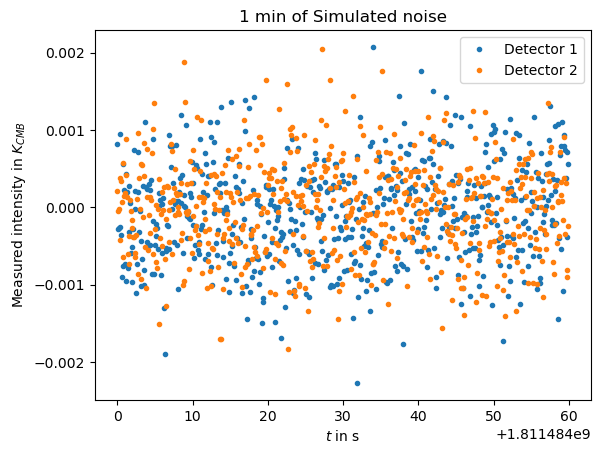

In [35]:
plt.plot(ob.shared["times"][0:600],ob.detdata["noise"][0][0:600],".", label = 'Detector 1') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.plot(ob.shared["times"][0:600],ob.detdata["noise"][1][0:600],".", label = 'Detector 2') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.xlabel('$t$ in s')
plt.ylabel('Measured intensity in $ K_{CMB}$')
plt.title('1 min of Simulated noise')
plt.legend(loc = 'best')
plt.show()

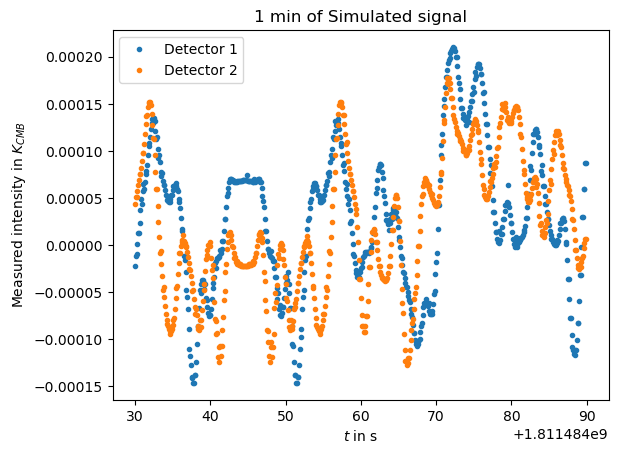

In [36]:
plt.plot(ob.shared["times"][300:900],ob.detdata["signal"][0][300:900],".", label = 'Detector 1') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.plot(ob.shared["times"][300:900],ob.detdata["signal"][1][300:900],".", label = 'Detector 2') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.xlabel('$t$ in s')
plt.ylabel('Measured intensity in $ K_{CMB}$')
plt.title('1 min of Simulated signal')
plt.legend(loc = 'best')
plt.show()

In [37]:
ob.detdata

<DetDataManager 2 local detectors, 50400 samples
    signal: shape=(2, 50400), dtype=float64, units='K'
    flags: shape=(2, 50400), dtype=uint8, units=''
    quats: shape=(2, 50400, 4), dtype=float64, units=''
    pixels: shape=(2, 50400), dtype=int64, units=''
    weights: shape=(1, 50400), dtype=float64, units=''
    noise: shape=(2, 50400), dtype=float64, units='K'
    total: shape=(2, 50400), dtype=float64, units='K'>

In [38]:
def modulo_180(x):
    if x>180:
        return (x-360)
    else:
        return x

In [39]:
def modulo_360(x):
    if x<0:
        return (x+360)
    else:
        return x

In [40]:
modulo_180_vec = np.vectorize(modulo_180)
modulo_360_vec = np.vectorize(modulo_360)


In [41]:
quats_1 = ob.detdata['quats'][0]
quats_2 = ob.detdata['quats'][1]

In [42]:
boresight_radec = ob.shared['boresight_radec']

In [43]:
#iso_radec = np.degrees(to_iso_angles(mult(xrot,boresight_radec)))
iso_radec = np.degrees(to_lonlat_angles(boresight_radec))

In [44]:
iso_angpix1 = np.degrees(to_lonlat_angles(quats_1))
iso_angpix2 = np.degrees(to_lonlat_angles(quats_2))

In [45]:
phi1,th1,psi1 = iso_angpix1
phi2,th2,psi2 = iso_angpix2


In [46]:
pix_arr1 = hp.ang2pix(nside=NSIDE,theta= iso_angpix1[0], phi = iso_angpix1[1], lonlat = True)

In [47]:
pix_arr2 = hp.ang2pix(nside=NSIDE,theta= iso_angpix2[0], phi = iso_angpix2[1], lonlat = True)

In [48]:
time = ob.shared["times"]

In [49]:
N_time = time.shape[0]
print(N_time)

50400


In [50]:
npix = hp.nside2npix(NSIDE)

In [51]:
pix1 = ob.detdata['pixels'][0]
pix2 = ob.detdata['pixels'][1]

In [52]:
pix2ang1 = hp.pix2ang(ipix=pix1,nside=NSIDE)
pix2ang2 = hp.pix2ang(ipix=pix2,nside=NSIDE)

In [53]:
pix2ang1[0].shape

(50400,)

## Create variables to store TOD

In [54]:
signal1 = ob.detdata['signal'][0]
signal2 = ob.detdata['signal'][1]
noise1 = ob.detdata['noise'][0]
noise2 = ob.detdata['noise'][1]
total1 = ob.detdata['total'][0]
total2 = ob.detdata['total'][1]


In [55]:
signal1.shape

(50400,)

In [56]:
ob.intervals

<IntervalsManager 13 lists
  throw_leftright: 55 intervals
  throw_rightleft: 55 intervals
  throw: 110 intervals
  scan_leftright: 55 intervals
  turn_leftright: 55 intervals
  scan_rightleft: 55 intervals
  turn_rightleft: 54 intervals
  elnod: 0 intervals
  scanning: 110 intervals
  turnaround: 109 intervals
  sun_up: 0 intervals
  sun_close: 0 intervals>

In [57]:
throw_lr_sample = np.array([(inter[2],inter[3]) for inter in ob.intervals['throw_leftright']])
throw_rl_sample = np.array([(inter[2],inter[3]) for inter in ob.intervals['throw_rightleft']])
scan_lr_sample = np.array([(inter[2],inter[3]) for inter in ob.intervals['scan_leftright']])
scan_rl_sample = np.array([(inter[2],inter[3]) for inter in ob.intervals['scan_rightleft']])

In [58]:
def interval_slice(arr, interval_list):
    return([arr[interval[0]:interval[1]] for interval in interval_list])

In [59]:
phi1.shape

(50400,)

In [60]:
RA_lr1 =interval_slice(arr = iso_angpix1[0],interval_list=throw_lr_sample)
RA_lr2 =interval_slice(arr = iso_angpix2[0],interval_list=throw_lr_sample)
signal_lr1 =interval_slice(arr = ob.detdata["signal"][0],interval_list=throw_lr_sample)
signal_lr2 =interval_slice(arr = ob.detdata["signal"][1],interval_list=throw_lr_sample)
total_lr1 =interval_slice(arr = ob.detdata["total"][0],interval_list=throw_lr_sample)
total_lr2 =interval_slice(arr = ob.detdata["total"][1],interval_list=throw_lr_sample)

In [61]:
schedule

<GroundSchedule site=SOUTH_POLE at -90.0 deg, -44.65 deg, 2843.0 m telescope SAT with 1 scans
  <GroundScan 'POLE_DEEP' at 2027-05-28T06:00:00+00:00 with El = 52.6 deg, Az 63.59 deg -- 134.26 deg>
>

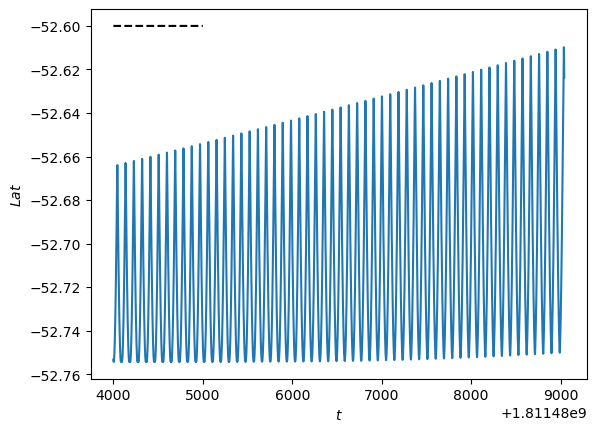

In [62]:
plt.plot(time[0:10000],-np.degrees(ob.shared['elevation'][0:10000]),'k--')
plt.plot(time,iso_radec[1],label = 'Boresight')
plt.xlabel(r'$t$')
plt.ylabel(r'$Lat$')
plt.savefig('Boresight_radec_latitude.png')
plt.show()


In [63]:
0.04*60/5000*3600

1.7279999999999998

In [64]:
mean_dec = np.degrees(np.mean(ob.shared['elevation']))
print(mean_dec-180)

-127.4


In [65]:
telescope

<Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -90.0 deg, alt = 2843.0 m, weather = None>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 029_003_SAT_f030_A]>>

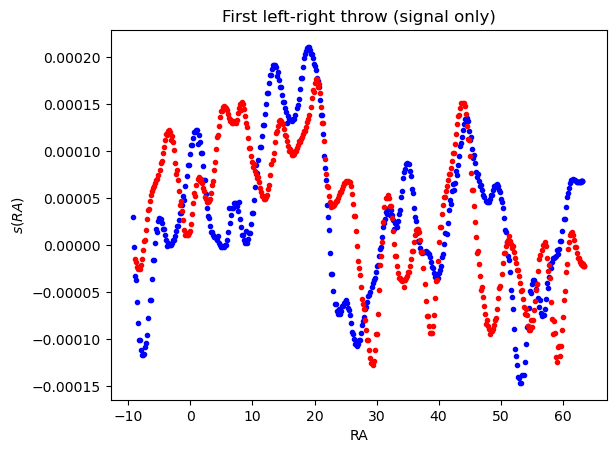

In [66]:

plt.plot(RA_lr1[0],signal_lr1[0],'b.')
plt.plot(RA_lr2[0],signal_lr2[0],'r.')
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.title('First left-right throw (signal only)')
#plt.plot(RA_lr1[54],signal_lr1[54],'b')
#plt.plot(RA_lr2[54],signal_lr2[54],'r')
plt.savefig('first_lr_throw.svg')

Text(0.5, 1.0, 'First left-right throw (signal only)')

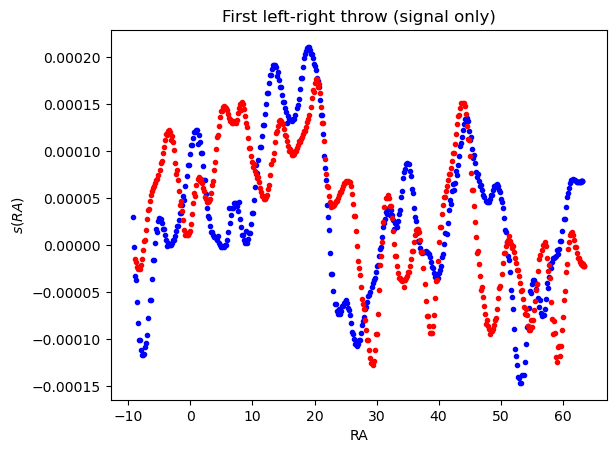

In [67]:
plt.plot(RA_lr1[0],signal_lr1[0],'b.')
plt.plot(RA_lr2[0],signal_lr2[0],'r.')
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.title('First left-right throw (signal only)')

Text(0.5, 1.0, '1st left-right throw')

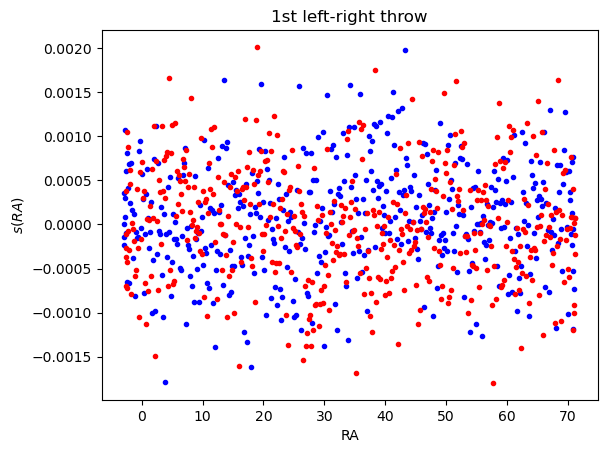

In [68]:
plt.plot(RA_lr1[20],total_lr1[20],'b.')
plt.plot(RA_lr2[20],total_lr2[20],'r.')
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.title('1st left-right throw')

In [69]:
psd_detector = np.array([si.welch(TOD,fs = 10,nperseg=4096) for TOD in ob.detdata["noise"]])

In [70]:
psd_detector.shape

(2, 2, 2049)

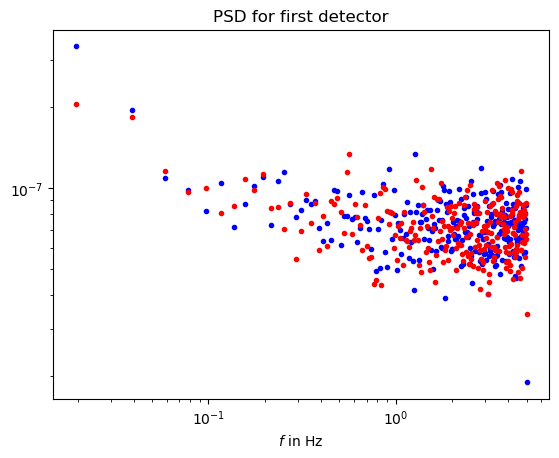

In [71]:
plt.plot(psd_detector[0,0,::8],psd_detector[0,1,::8],".b", label = 'First') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.plot(psd_detector[1,0,::8],psd_detector[1,1,::8],".r", label = 'Second') ##Detdata has several data, signal is under "signal", detdata is a 2D array

plt.xscale('log')
plt.yscale('log')

plt.xlabel('$f$ in Hz')
plt.title('PSD for first detector')
plt.show()

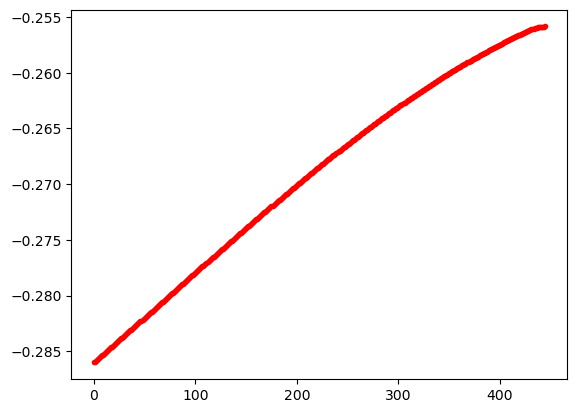

In [72]:
plt.plot(np.arange(0,RA_lr1[0].shape[0]),RA_lr1[0]-RA_lr2[0],'r.')


## Destriping

In [73]:
templates = [toast.templates.Offset(name="baselines", step_time = step_0)]

template_matrix = toast.ops.TemplateMatrix(templates=templates)

In [74]:
ob.detdata

<DetDataManager 2 local detectors, 50400 samples
    signal: shape=(2, 50400), dtype=float64, units='K'
    flags: shape=(2, 50400), dtype=uint8, units=''
    quats: shape=(2, 50400, 4), dtype=float64, units=''
    pixels: shape=(2, 50400), dtype=int64, units=''
    weights: shape=(1, 50400), dtype=float64, units=''
    noise: shape=(2, 50400), dtype=float64, units='K'
    total: shape=(2, 50400), dtype=float64, units='K'>

In [75]:
binner = toast.ops.BinMap(pixel_pointing = pixels, stokes_w = weights)
mapmaker = toast.ops.MapMaker(binning = binner, template_matrix=template_matrix)

In [76]:
mapmaker.save_cleaned = True

In [77]:
scan_map.pixel_dist

'pixel_dist'

In [78]:
mapmaker.iter_max = 50
mapmaker.convergence = 1.0e-10


In [79]:
mapmaker.mc_mode

False

In [80]:
binner.stokes_weights = weights

In [81]:
ob.detdata

<DetDataManager 2 local detectors, 50400 samples
    signal: shape=(2, 50400), dtype=float64, units='K'
    flags: shape=(2, 50400), dtype=uint8, units=''
    quats: shape=(2, 50400, 4), dtype=float64, units=''
    pixels: shape=(2, 50400), dtype=int64, units=''
    weights: shape=(1, 50400), dtype=float64, units=''
    noise: shape=(2, 50400), dtype=float64, units='K'
    total: shape=(2, 50400), dtype=float64, units='K'>

In [82]:
cleaned_TOD = {}

In [83]:
for detdata in ["noise", "signal","total"]:
    binner.det_data=detdata
    mapmaker.binning= binner
    mapmaker.det_data=detdata
    mapmaker.output_dir = 'customdestriping/'+detdata
    mapmaker.apply(data)
    cleaned_TOD[detdata] = np.copy(ob.detdata['MapMaker_cleaned'])

TOAST INFO: SolveAmplitudes begin building flags for solver
TOAST INFO: SolveAmplitudes  finished flag building in 0.00 s
TOAST INFO: SolveAmplitudes begin build of solver covariance
TOAST INFO: SolveAmplitudes begin build of rcond flags
TOAST INFO: SolveAmplitudes  finished build of solver covariance in 0.02 s
TOAST INFO: SolveAmplitudes Solver flags cut 7178 / 100800 = 7.12% of samples
TOAST INFO: SolveAmplitudes begin RHS calculation
TOAST INFO: SolveAmplitudes  finished RHS calculation in 0.02 s
TOAST INFO: SolveAmplitudes begin PCG solver
TOAST INFO: MapMaker initial residual = 2478314353171.883 in 0.01 s
TOAST INFO: MapMaker iteration    0, relative residual = 2.624085e-03 in 0.01 s
TOAST INFO: MapMaker iteration    1, relative residual = 3.568523e-04 in 0.01 s
TOAST INFO: MapMaker iteration    2, relative residual = 2.182251e-05 in 0.01 s
TOAST INFO: MapMaker iteration    3, relative residual = 1.958745e-05 in 0.01 s
TOAST INFO: MapMaker iteration    4, relative residual = 6.767

In [84]:
signal_destriping_bin = hp.read_map(filename='customdestriping/signal/MapMaker_binmap.fits',field=None)
noise_destriping_bin = hp.read_map(filename='customdestriping/noise/MapMaker_binmap.fits',field=None)
total_destriping_bin = hp.read_map(filename='customdestriping/total/MapMaker_binmap.fits',field=None)
signal_destriping = hp.read_map(filename='customdestriping/signal/MapMaker_map.fits',field=None)
noise_destriping = hp.read_map(filename='customdestriping/noise/MapMaker_map.fits',field=None)
total_destriping = hp.read_map(filename='customdestriping/total/MapMaker_map.fits',field=None)

In [85]:
cleaned_TOD['signal'].shape

(2, 50400)

In [86]:
hit_map = hp.read_map('customdestriping/signal/MapMaker_hits.fits')

In [87]:
def masked(m1, mask):
    resul = np.zeros(m1.shape)
    resul[mask==0] = hp.UNSEEN
    resul[mask!=0] = m1[mask!=0]
    return resul

In [88]:
signal_mask = masked(signal_destriping,hit_map)
noise_mask = masked(noise_destriping,hit_map)


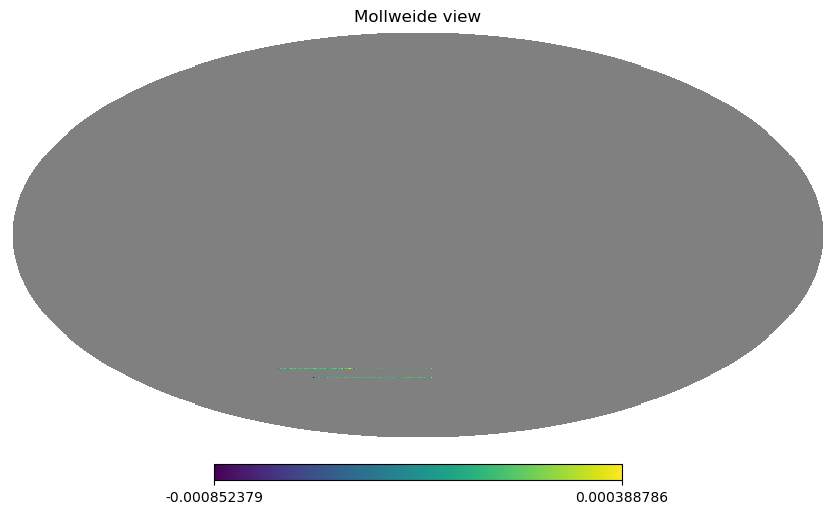

In [89]:
hp.mollview(noise_mask)

## Find angles for pixel centers

In [90]:
hit_pix = np.nonzero(hit_map!=0)
hit_pix[0].shape

(1602,)

In [91]:
hit_ang = hp.pix2ang(nside=  NSIDE,ipix = hit_pix[0],lonlat=True)

In [92]:
#plt.plot(np.arange(0,905), hit_ang[1],'.')

## Set each pixel to Dec angles

In [93]:
#plt.plot(np.arange(0,905), hit_ang[1],'.')

In [94]:
set_dec = set(hit_ang[1])

In [95]:
#dec0,dec1,dec2 = set_dec
set_dec

{-54.62873786056787,
 -54.532821718397116,
 -54.43687989547715,
 -50.86815892553736,
 -50.77117424677809,
 -50.67416030744562}

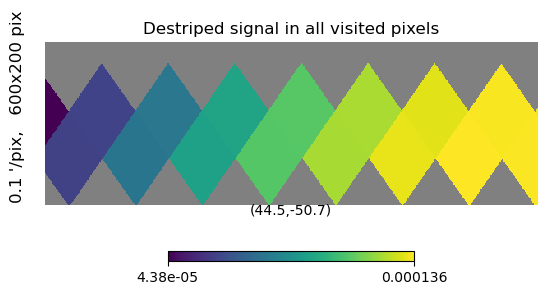

In [96]:
hp.gnomview(signal_mask,rot = (44.5,-50.7),xsize = 600,ysize=200,reso = .1,   title = 'Destriped signal in all visited pixels')
plt.savefig('destriping_healpix_pixelization.svg')

## Compute residuals (input-output)

In [101]:
input_mask = np.ones(signal_destriping.shape)*hp.UNSEEN
input_mask[hit_map!=0] = truesky_GC512[hit_map!=0]

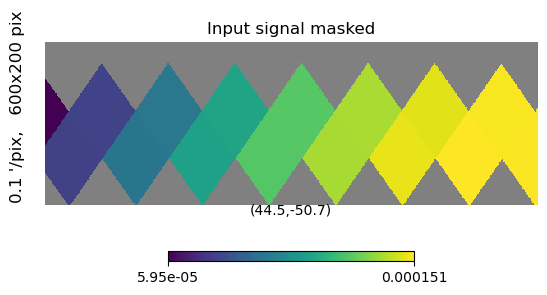

In [102]:
hp.gnomview(input_mask,rot = (44.5,-50.7),xsize = 600,ysize=200,reso = .1,   title = 'Input signal masked')


In [108]:
res1 = input_mask-signal_destriping_bin
res1 = masked(res1,hit_map)

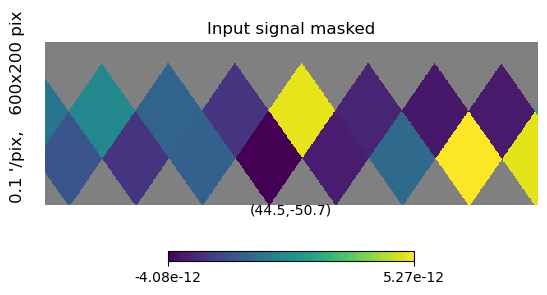

In [109]:
hp.gnomview(res1,rot = (44.5,-50.7),xsize = 600,ysize=200,reso = .1,   title = 'Input signal masked')


In [97]:
set_dec

{-54.62873786056787,
 -54.532821718397116,
 -54.43687989547715,
 -50.86815892553736,
 -50.77117424677809,
 -50.67416030744562}

In [98]:
hit_0 = np.where(hit_ang[1]==dec0)
hit_1 = np.where(hit_ang[1]==dec1)
hit_2 = np.where(hit_ang[1]==dec2)


NameError: name 'dec0' is not defined

In [ ]:
strip0 = np.where(np.abs(th1-dec0)<1e-2)
strip1 = np.where(np.abs(th1-dec1)<1e-2)
strip2 = np.where(np.abs(th1-dec2)<1e-2)


In [ ]:
type(strip0)

In [ ]:
print(strip0[0].shape)
print(strip0[0].shape)


In [ ]:
np.where(strip0[0]!=strip0[0])


In [ ]:
time_0 = time[strip0]
time_1 = time[strip1]
time_2 = time[strip2]


In [ ]:
strip0

In [ ]:
np.where((strip0[0]>50)&(strip0[0]<500))

In [ ]:
temp = [np.where((strip0[0]>=throw[0])&(strip0[0]<=throw[1]))[0] for throw in throw_lr_sample]

In [ ]:
print(temp[0].shape)

In [ ]:
strip0_lr1 = [strip0[0][indices] for indices in temp]

In [ ]:
#strip0_lr1

### Divide in subscans

In [ ]:
type(throw_lr_sample)

In [ ]:
strip0_lr1 = interval_slice(strip0[0],throw_lr_sample)

In [ ]:
throw_lr_sample[0]

In [ ]:
#strip0_lr1

In [ ]:
signal_destriping.shape

In [ ]:
hitmap_0 = hit_pix[0][hit_0]

signal_map_0 = np.ones(signal_mask.shape)*hp.UNSEEN
signal_map_0[hitmap_0] = signal_mask[hitmap_0]

In [ ]:
hitmap_1 = hit_pix[0][hit_1]

signal_map_1 = np.ones(signal_mask.shape)*hp.UNSEEN
signal_map_1[hitmap_1] = signal_mask[hitmap_1]

In [ ]:
hitmap_2 = hit_pix[0][hit_2]

signal_map_2 = np.ones(signal_mask.shape)*hp.UNSEEN
signal_map_2[hitmap_2] = signal_mask[hitmap_2]

In [ ]:
print(hit_ang[0][hit_0].shape)
print(hitmap_0.shape)

In [ ]:
time_slice = interval_slice(arr =time,interval_list=throw_lr_sample)
time_lr1 = time_slice[0]

In [ ]:
print(time_slice[10][-1]-time_slice[10][0])

In [ ]:
plt.plot(phi1[strip0_lr1[0]],total1[strip0_lr1[0]],'b.', label = 'Det 1')
plt.plot(phi2[strip0_lr1[0]],total2[strip0_lr1[0]],'r.',label = 'Det 2')

#plt.plot(phi1[strip0_lr1[1]],total1[strip0_lr1[1]],'b--')
#plt.plot(phi2[strip0_lr1[1]],total2[strip0_lr1[1]],'r--')

plt.plot(modulo_180_vec(hit_ang[0][hit_0]),total_destriping_bin[hitmap_0],'kx',label = 'After destriping + template substraction')
#plt.plot(modulo_180_vec(hit_ang[0][hit_0]),total_destriping[hitmap_0],'.',color = 'gray',label = 'After destriping')

plt.xlim(left = -6,right = 10)
plt.ylim(bottom = -.0015,top = .0015)

plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.legend(loc = 'lower left')
plt.title('First left-right scan')
plt.show()

In [ ]:
hp.gnomview(signal_map_0,rot = (44.5,dec0),xsize = 600,ysize=200,reso = .1,   title = 'Destriped signal in visited pixels for ring at dec '+ str(dec0))
plt.savefig('destriping_healpix_pixelization_dec0.svg')

In [ ]:
hp.gnomview(signal_map_1,rot = (44.5,dec1),xsize = 600,ysize=200,reso = .1,   title = 'Destriped signal in visited pixels for ring at dec '+ str(dec1))
plt.savefig('destriping_healpix_pixelization_dec1.svg')

In [ ]:
hp.gnomview(signal_map_2,rot = (77,dec2),xsize = 600,ysize=200,reso = .5,   title = 'Destriped signal in visited pixels for one ring')

In [ ]:
#plt.plot((hit_ang[0]+180)%360-180,total_destriping[hit_pix],'.')
#plt.plot(modulo_180_vec(hit_ang[0]),((hit_ang[0]+180)%360-180),'.')

#plt.plot(hit_ang[0],signal_destriping[hit_pix],'k.',label = 'After destriping')
plt.plot(modulo_180_vec(hit_ang[0]),signal_destriping_bin[hit_pix],'g.',label = 'After destriping + template substraction')
#plt.plot(hit_ang[0],total_destriping[hit_pix]-total_destriping_bin[hit_pix],'k.',label = 'Template fitting')

plt.plot(RA_lr1[0][::3],signal_lr1[0][::3],'b.',label = 'Detector 1')
plt.plot(RA_lr2[0][::3],signal_lr2[0][::3],'r.',label = 'Detector 2')
plt.plot(RA_lr1[50][::3],signal_lr1[50][::3],'bx',label = 'Detector 1')
plt.plot(RA_lr2[50][::3],signal_lr2[50][::3],'rx',label = 'Detector 2')
#plt.xlim(left = 0,right = 50)
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.legend(loc = 'lower left')
plt.title('First left-right scan (signal only)')
#plt.plot(RA_lr1[54],signal_lr1[54],'b')
#plt.plot(RA_lr2[54],signal_lr2[54],'r')

In [ ]:
#plt.plot((hit_ang[0]+180)%360-180,total_destriping[hit_pix],'.')
#plt.plot(modulo_180_vec(hit_ang[0]),((hit_ang[0]+180)%360-180),'.')

#plt.plot(hit_ang[0],signal_destriping[hit_pix],'k.',label = 'After destriping')
plt.plot(modulo_180_vec(hit_ang[0]),total_destriping_bin[hit_pix],'k.',label = 'After destriping + template substraction')
#plt.plot(hit_ang[0],total_destriping[hit_pix]-total_destriping_bin[hit_pix],'k.',label = 'Template fitting')

plt.plot(RA_lr1[0][::6],total_lr1[0][::6],'b.',label = 'Detector 1')
plt.plot(RA_lr2[0][::6],total_lr2[0][::6],'r.',label = 'Detector 2')
plt.plot(RA_lr1[50][::6],total_lr1[50][::6],'bx',label = 'Detector 1')
plt.plot(RA_lr2[50][::6],total_lr2[50][::6],'rx',label = 'Detector 2')
#plt.xlim(left = 0,right = 50)
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.legend(loc = 'lower left')
plt.title('First left-right scan (signal+noise only)')
#plt.plot(RA_lr1[54],signal_lr1[54],'b')
#plt.plot(RA_lr2[54],signal_lr2[54],'r')

In [ ]:
plt.plot(modulo_360_vec(RA_lr1[0]),total_lr1[0],'b.')
plt.plot(modulo_360_vec(RA_lr2[0]),total_lr2[0],'r.')
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.title('First left-right throw (signal only)')
#plt.plot(RA_lr1[54],signal_lr1[54],'b')
#plt.plot(RA_lr2[54],signal_lr2[54],'r')

In [ ]:
plt.plot(modulo_180_vec(hit_ang[0]),noise_destriping[hit_pix]+signal_destriping[hit_pix],'k.',label = 'Signal + noise')
plt.plot(modulo_180_vec(hit_ang[0]),total_destriping[hit_pix],'r.',label = 'Total')
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.show()

In [ ]:
plt.plot(modulo_180_vec(hit_ang[0]),noise_destriping[hit_pix]+signal_destriping[hit_pix]-total_destriping[hit_pix],'.',label = 'Signal+noise-Total')
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.show()

In [ ]:
cleaned_TOD

In [ ]:
time[50]-time[0]

In [ ]:
plt.plot(time[:2000],(signal1-cleaned_TOD['signal'][0])[:2000],'b.',label = 'Detector 1')
plt.plot(time[:2000],(signal2-cleaned_TOD['signal'][1])[:2000],'r.',label = 'Detector 2')
#plt.plot(time[:200],signal1[:200],'bx',label = 'Detector 1')
#plt.plot(time[:200],signal2[:200],'rx',label = 'Detector 2')
plt.xlabel('$t$')
plt.ylabel(r'$s(t)$')
plt.legend(loc = 'lower left')
plt.title('Baselines')
plt.savefig('baselines.svg')

## Create a pointing matrix

Compute $P^T P$. It is block diagonal of shape $3n_{pix}^2$, with each block having the form $\begin{pmatrix}N & \sum c &\sum s \\ \sum c &\sum c^2 &\sum cs \\ \sum s &\sum cs &\sum s^2\end{pmatrix}$

In [ ]:
pointing_arr = np.zeros((2*N_time,3*npix),dtype = complex)

In [ ]:
pix_arr1.shape

In [ ]:
for t in range(N_time):
    for pol in range(3):
        pointing_arr[t, pol*pix_arr1[t]] = 1
        pointing_arr[t, pol*pix_arr1[t]] = np.cos(2*psi1[t])
        pointing_arr[t, pol*pix_arr1[t]] = np.sin(2*psi1[t])
        pointing_arr[2*t, pol*pix_arr2[t]] = 1
        pointing_arr[2*t, pol*pix_arr2[t]] = np.cos(2*psi2[t])
        pointing_arr[2*t, pol*pix_arr2[t]] = np.sin(2*psi2[t])

In [ ]:
pointing_arr.shape

In [ ]:
3*npix

In [ ]:
print(pointing_arr)

# Hit maps

In [ ]:
hitmap1 = np.zeros(npix,dtype = complex)

for pix in pix_arr1:
    hitmap1[pix]+=1
#hitmap1[hitmap1==0] = hp.UNSEEN
hp.mollview(hitmap1)

In [ ]:
hitmap2 = np.zeros(npix,dtype = complex)

for pix in pix_arr2:
    hitmap2[pix]+=1
#hitmap2[hitmap2==0] = hp.UNSEEN

hp.mollview(hitmap2)

In [ ]:
hitmap_tot = hitmap1+hitmap2
hitmap_tot[hitmap_tot==0] = hp.UNSEEN
hp.mollview(hitmap_tot)

In [ ]:
hp.gnomview(hitmap_tot-hit_map,rot = (50,dec1),xsize = 600,ysize=200,reso = 5,   title = 'Visited pixels')

In [ ]:
hp.gnomview(hitmap_tot,rot = (50,dec1),xsize = 600,ysize=200,reso = 1,   title = 'Visited pixels')

In [ ]:
hp.gnomview(hitmap1,rot = (50,dec1),xsize = 600,ysize=200,reso = 1,   title = 'Visited pixels by detector 1')

In [ ]:
hp.gnomview(hitmap2,rot = (50,dec1),xsize = 600,ysize=200,reso = 1,   title = 'Visited pixels by detector 2')

In [ ]:
t_arr = np.arange(0,1000)

In [ ]:
100%7

In [ ]:
def triangle(N, t1,t2,slope):
    resul = np.zeros(N)
    for i in range(N-1):
        q = i//t2
        r = i%t2
        if r<t1:
            resul[i+1] = resul[i]+slope
        else : 
            resul[i+1] = resul[i]-slope
    return(resul)

In [ ]:
res_arr = triangle(1000,35,60,3)

In [ ]:
plt.plot(res_arr,-t_arr-550,label = 'Detector 1')
plt.plot(res_arr+50,-t_arr-850,label = 'Detector 2')
plt.vlines(x=50,ymin = -3000, ymax = 1000,colors='k', linestyles='--')
plt.legend(loc = 'upper center')
plt.xlabel('Right Ascension')
plt.ylabel('Time')
plt.xlim(right = 650)
plt.ylim(top = 0,bottom = -2000)
plt.yticks([])
plt.xticks([50,res_arr[-1]],['$RA_1$','$RA_2$'])
plt.savefig('schema_principe.pdf')